In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import os
import pickle
import re

from glob import glob
from ffpyplayer.player import MediaPlayer

%matplotlib inline

In [15]:
img_glob = glob('data/train/*/*.jpg')
name_glob = glob('data/train/*')

base = os.path.dirname('')
TRAIN_DIR = os.path.join(base + 'data/train')
TEST_DIR = os.path.join(base + 'data/test')

prototxt_file = os.path.join(base + 'data/deploy.prototxt.txt')
caffemodel_file = os.path.join(base + 'data/weights.caffemodel')

In [16]:
name_glob

['data/train\\dahyun',
 'data/train\\juri',
 'data/train\\sohee',
 'data/train\\suyun',
 'data/train\\yeonhee',
 'data/train\\yunkyoung']

In [17]:
name_glob = glob('data/train/*')
names = []

for n in name_glob:
    for i in range(10):
        names.append(n[11:])

In [18]:
face_model = cv2.dnn.readNetFromCaffe(prototxt_file, caffemodel_file)

In [19]:
IMG_SIZE = 128
extracted_faces = []

for img in img_glob:
    a = cv2.imread(img)
    (h,w) = a.shape[:2]
    blob = cv2.dnn.blobFromImage(a, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    face_model.setInput(blob)
    detector = face_model.forward()
    
    for i in range(0, detector.shape[0]):
        rect = detector[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = rect.astype("int")

        confidence = detector[0, 0, i, 2]
        if (confidence > 0.5):
            cv2.rectangle(a, (startX, startY), (endX, endY), (255, 255, 255), 2)
        
        face = a[startY:endY, startX:endX]
        resized_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        
        extracted_faces.append(resized_face)
        
# save to disk
data = {'extracted_faces': extracted_faces, 'names': names}
with open('extracted_faces.pickle', 'wb') as f:
    pickle.dump(data, f)

In [20]:
a = cv2.imread('data/train\yeonhee\yeonhee6.jpg')
(h,w) = a.shape[:2]
blob = cv2.dnn.blobFromImage(a, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
face_model.setInput(blob)
detector = face_model.forward()
    
for i in range(0, detector.shape[0]):
    rect = detector[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = rect.astype("int")

    confidence = detector[0, 0, i, 2]
    if (confidence > 0.5):
        cv2.rectangle(a, (startX, startY), (endX, endY), (255, 255, 255), 2)
        
    face = a[startY:endY, startX:endX]
    face = cv2.resize(face, (128,128))
#     face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    
cv2.imshow('face', face)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Checkpoint

In [21]:
# load the saved extracted faces pickle
with open('extracted_faces.pickle', 'rb') as f:
    face_loader = pickle.load(f)

raw_data = list(face_loader.values())
cv2.imshow('test', raw_data[0][1])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [23]:
from torchvision import datasets, transforms

root = './data'

transform = transforms.Compose([transforms.ToTensor()])
train = datasets.MNIST(root=root, train=True, transform=transform, download=True)

In [24]:
print(train.data.shape)
print(train.data[0].shape)
print(train.targets)
print(train.targets.shape)
print(type(train.data))

torch.Size([60000, 28, 28])
torch.Size([28, 28])
tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000])
<class 'torch.Tensor'>


In [25]:
# split between features and labels
features = raw_data[0]
labels = raw_data[1]

train_data = np.asarray(features)
train_labels = np.asarray(labels)

print(train_data.shape)
print(train_labels.shape)

(60, 128, 128, 3)
(60,)


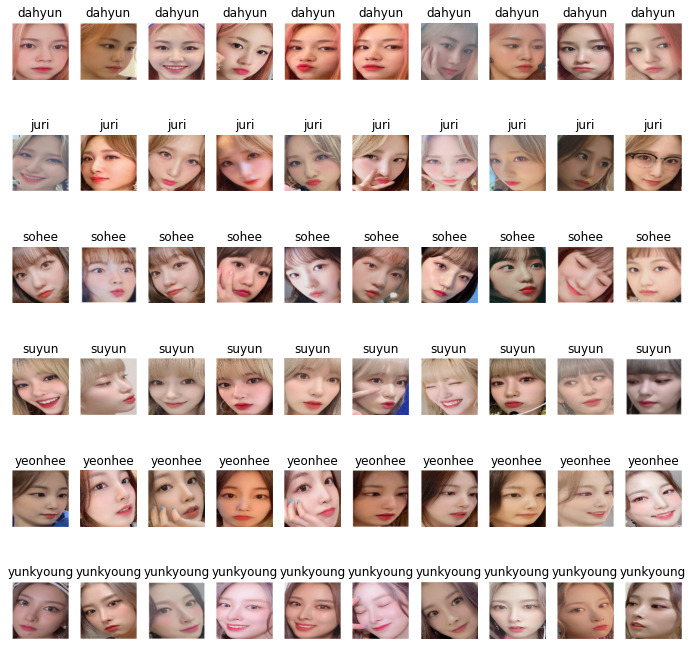

In [28]:
# show all faces for each members
fig, ax = plt.subplots(6, 10, figsize=(12,12))

for (x, y, axi) in zip(features, labels, ax.flatten()):
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    axi.imshow(x)
    axi.set_title(y)
    axi.axis('off')

In [ ]:
# def play_video(path):
#     frame_name = 'Video'
#     vid = cv2.VideoCapture(path)
# #     audio = MediaPlayer(path)
    
#     cv2.namedWindow(frame_name, cv2.WND_PROP_FULLSCREEN)
#     cv2.setWindowProperty(frame_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
#     fps = vid.get(cv2.CAP_PROP_FPS)
#     print('Video fps:', fps)
    
#     while vid.isOpened():
#         ret, frame = vid.read()
# #         audio_frame, val = audio.get_frame()
        
#         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         face = face_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(30,30), maxSize=(200,200))
#         for (x, y, w, h) in face:
#             cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
#         if not ret:
#             print('End of video...')
#             break
#         cv2.imshow(frame_name, frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
# #         if val != 'eof' and audio_frame is not None:
# #             img, t = audio_frame
        
#     vid.release()
#     cv2.destroyAllWindows()

In [ ]:
# play_video('data/rcpc_loveisover_mcountdown.webm')